In [101]:
%matplotlib inline

In [102]:
import os
import pickle as pkl
import numpy as np
from matplotlib import pyplot as plt

from viz_helpers import set_cycler
from helpers import makedir_if_not_there

In [103]:
def load_performance_matrix():
    pass

In [104]:
# graphs = ['lattice-1024', 'infectious']
graphs = ['grqc']
model = 'si'
methods = ['our', 'netfill', 'min-steiner-tree']


In [105]:
def iter_through_obs_fraction(method, graph, model, cascade_fraction, obs_fractions):
    return ['eval/{}/{}-m{}-s{}-o{}-omuniform.pkl'.format(method, graph, model, cascade_fraction, obs_fraction)
            for obs_fraction in obs_fractions]

In [106]:
def iter_through_cascade_fraction(method, graph, model, obs_fraction, cascade_fractions):
    return ['eval/{}/{}-m{}-s{}-o{}-omuniform.pkl'.format(method, graph, model, cascade_fraction, obs_fraction)
            for cascade_fraction in cascade_fractions]

In [107]:
def load_batch(paths):
    return [pkl.load(open(path, 'rb')) for path in paths]

In [108]:
def extract_batch(objs, extractor=lambda s: s['50%']):
    return [extractor(o) for o in objs]

In [109]:
def together(*args, path_iter_func=None, **kwargs):
    assert path_iter_func is not None
    return extract_batch(load_batch(path_iter_func(*args, **kwargs)))

In [110]:
plt.style.use('paper')

In [111]:
def load_data_along_one_dimension(graph, model, dim1_vars,
                                  path_iter_func,
                                  **kwargs):
    rows = []
    for v in dim1_vars:
        row = together(v, graph, model,
                       path_iter_func=path_iter_func,
                       **kwargs)
        rows.append(row)
    return rows

In [112]:
def plot(rows, dim1_vars, dim2_vars, xlabel, ylabel, title=None, output=None):
    fig, ax = plt.subplots(1, 1)
    set_cycler(ax)
    for r in rows:
        ax.plot(dim2_vars, r)
    # ax.legend(dim1_vars, loc='best')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)    
    fig.tight_layout()
    
    if title is not None:
        ax.set_title(title)
    
    if output is not None:
        fig.savefig(output)

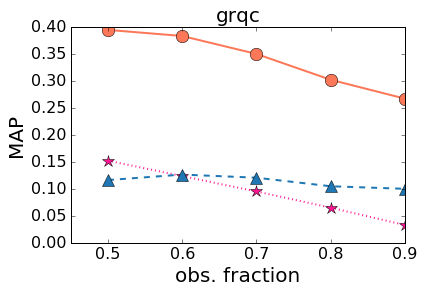

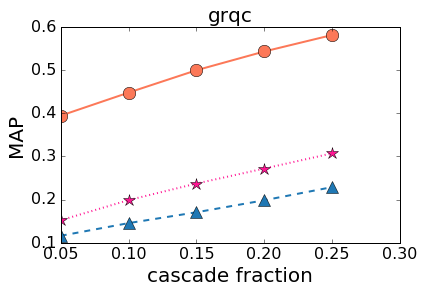

In [114]:
for graph in graphs:
    #########
    # vary over obs fractions
    ########
    output_dir = 'figs/different-obs-fractions'
    makedir_if_not_there(output_dir)

    # cascade_fraction = '0.1'
    cascade_fraction = '0.05'
    obs_fractions = ["0.5", "0.6", "0.7", "0.8", "0.9"]

    kwargs = {'cascade_fraction': cascade_fraction,
              'obs_fractions': obs_fractions}
    rows = load_data_along_one_dimension(graph, model, methods, 
                                         iter_through_obs_fraction, 
                                         **kwargs)
    plot(rows, dim1_vars, dim2_vars, 'obs. fraction', 'MAP', graph,
         output=os.path.join(output_dir, '{}.png'.format(graph)))

    #########
    # vary over cascade fractions
    #########

    output_dir = 'figs/different-cascade-fractions'
    makedir_if_not_there(output_dir)


    # cascade_fractions = ["0.1", "0.2", "0.3", "0.4", "0.5"]
    cascade_fractions = ["0.05", "0.1", "0.15", "0.2", "0.25"]
    kwargs = {'cascade_fractions': cascade_fractions,
              'obs_fraction': 0.5}
    rows = load_data_along_one_dimension(graph, model, methods, 
                                         iter_through_cascade_fraction, 
                                         **kwargs)
    plot(rows, dim1_vars, list(map(float, cascade_fractions)), 'cascade fraction', 'MAP', graph,
         output=os.path.join(output_dir, '{}.png'.format(graph)))